# Build nearest neighbor graph of spikes using spikeinterface spikesorting modules
- this notebooks 
    1. grabs all spikes in a recording (found with detect peaks) 
    2. computes sparse euclidean nearest neighbors over chunks of the recording
    3. merges that graph into a single nearest neighbors graph

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path
import spikeinterface.full as si
import probeinterface
from probeinterface.plotting import plot_probe
import matplotlib.pyplot as plt
import numpy as np

In [4]:
base_folder = Path('/n/groups/datta/tim_sainburg/datasets/guitchounts_2_22/')
dataset_folder = base_folder/'Record Node 106'
probe_file = base_folder / 'A4x16-Poly3-5mm-20-200-160-H64LP.prb'

### Load dataset

In [5]:
rec = si.read_openephys(dataset_folder)
probe = probeinterface.io.read_prb(probe_file)
rec = rec.set_probe(probe.probes[0])

/n/groups/datta/tim_sainburg/datasets/guitchounts_2_22/Record Node 106/experiment1/recording1/continuous/Rhythm_FPGA-103.0/continuous.dat
/n/groups/datta/tim_sainburg/datasets/guitchounts_2_22/Record Node 106/experiment1/recording1/continuous/Rhythm_FPGA-103.0/continuous.dat


In [6]:
probe.probes[0]._contact_positions[:,0]

array([  0. ,   0. ,   0. ,   0. ,   0. ,  17.3,  17.3,  17.3,  17.3,
        17.3,  17.3,  34.6,  34.6,  34.6,  34.6,  34.6, 200. , 200. ,
       200. , 200. , 200. , 217.3, 217.3, 217.3, 217.3, 217.3, 217.3,
       234.6, 234.6, 234.6, 234.6, 234.6, 400. , 400. , 400. , 400. ,
       400. , 417.3, 417.3, 417.3, 417.3, 417.3, 417.3, 434.6, 434.6,
       434.6, 434.6, 434.6, 600. , 600. , 600. , 600. , 600. , 617.3,
       617.3, 617.3, 617.3, 617.3, 617.3, 634.6, 634.6, 634.6, 634.6,
       634.6])

In [7]:
probe_positions = probe.probes[0]._contact_positions
margin = 100
probe_bounds_x = [
    np.min(probe_positions[:, 0]) - margin,
    np.max(probe_positions[:, 0]) + margin,
]
probe_bounds_y = [
    np.min(probe_positions[:, 1]) - margin,
    np.max(probe_positions[:, 1] + margin),
]

(-65.0, 235.0)

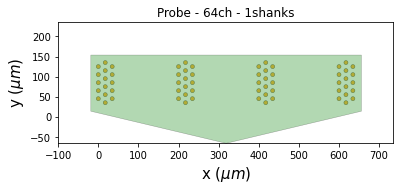

In [8]:
fig, ax = plt.subplots()
plot_probe(rec.get_probe(), ax=ax)
ax.set_xlim(probe_bounds_x)
ax.set_ylim(probe_bounds_y)

### Preprocess

In [9]:
job_kwargs = dict(
    n_jobs=-1,
    chunk_memory='10M',
    progress_bar=True,
)

In [10]:
preprocess_folder = base_folder / 'spikeinterface-preprocess'

In [11]:
try:
    rec_filtered = si.bandpass_filter(rec, freq_min=300.0, freq_max=6000.0)
    rec_preprocessed = si.common_reference(
        rec_filtered, reference="global", operator="median"
    )
    rec_preprocessed.save(folder=preprocess_folder, **job_kwargs)
except AssertionError:
    print("already done")

already done


In [12]:
# load back
rec_preprocessed = si.load_extractor(preprocess_folder)
rec_preprocessed

BinaryRecordingExtractor: 64 channels - 1 segments - 30.0kHz - 4341.330s
  file_paths: ['/n/groups/datta/tim_sainburg/datasets/guitchounts_2_22/spikeinterface-preprocess/traces_cached_seg0.raw']

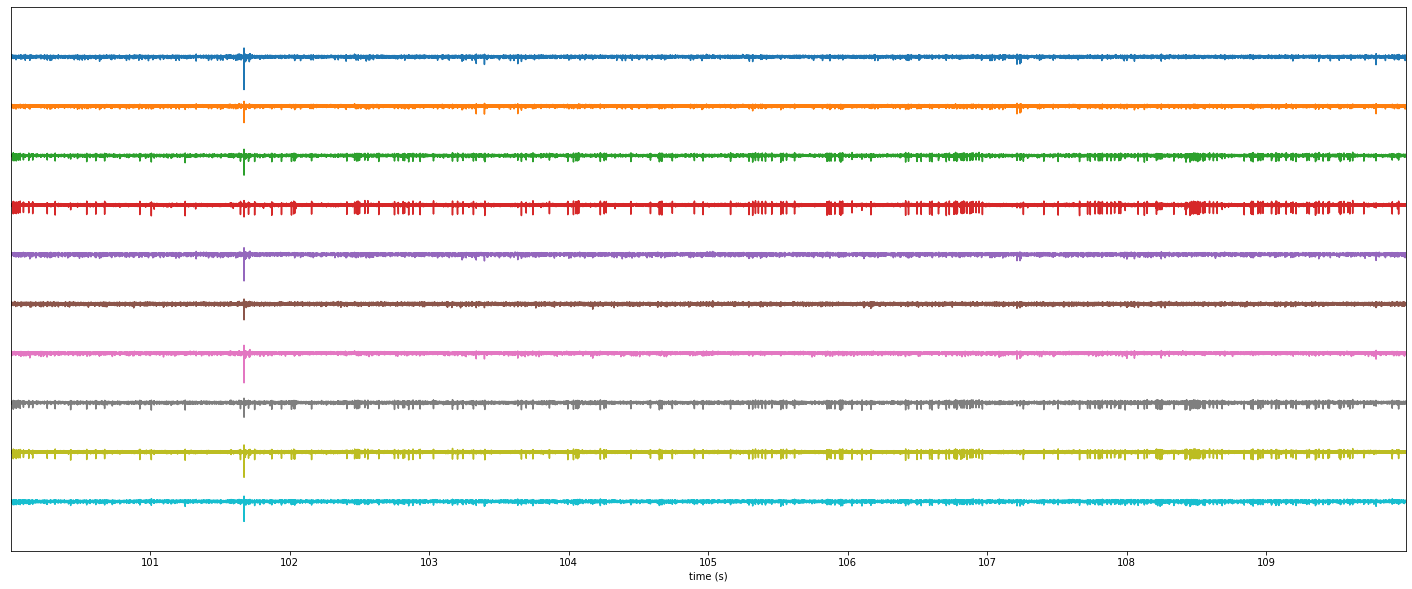

In [13]:
# plot and check spikes
fig, ax = plt.subplots(figsize=(25, 10))
si.plot_timeseries(
    rec_preprocessed, time_range=(100, 110), channel_ids=rec.channel_ids[0:10], ax=ax
)

### Detect peaks

In [14]:
from spikeinterface.sortingcomponents import detect_peaks

In [15]:
# estimate noise
noise_levels = si.get_noise_levels(rec_preprocessed, return_scaled=False)

Text(0.5, 1.0, 'noise across channel')

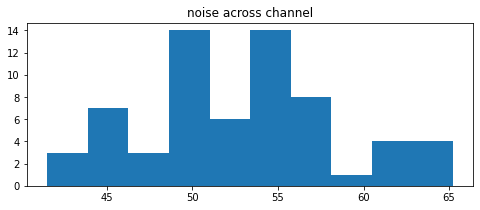

In [16]:
fig, ax = plt.subplots(figsize=(8,3))
ax.hist(noise_levels)
ax.set_title('noise across channel')

In [17]:
peak_folder = base_folder / 'spikeinterface_peaks'
peaks_file = peak_folder / 'peaks.npy'

In [18]:
if peaks_file.exists():
    print("peaks file already exists, loading")
    peaks = np.load(peaks_file)
else:
    # grab peaks (~2-3m for 1hr 64ch)
    peaks = detect_peaks(
        rec_preprocessed,
        method="locally_exclusive",
        local_radius_um=100,
        peak_sign="neg",
        detect_threshold=10,
        n_shifts=5,
        noise_levels=noise_levels,
        **job_kwargs
    )
    np.save(peaks_file, peaks)

peaks file already exists, loading


In [19]:
print(peaks.shape)

(221083,)


In [20]:
peaks[:2]

array([( 936, 3, -1304., 0), (2037, 3, -1352., 0)],
      dtype=[('sample_ind', '<i8'), ('channel_ind', '<i8'), ('amplitude', '<f8'), ('segment_ind', '<i8')])

### Localize spikes (for visualization only)

In [21]:
peak_location_file = peak_folder / 'peak_locations_monopolar_triangulation.npy'

In [22]:
if peak_location_file.exists():
    print("peaks file already exists, loading")
    peak_locations = np.load(peak_location_file)
else:
    # find the peaks using monopolar triangulation
    peak_locations = localize_peaks(
        rec_preprocessed,
        peaks,
        ms_before=0.3,
        ms_after=0.6,
        method="monopolar_triangulation",
        method_kwargs={"local_radius_um": 100.0, "max_distance_um": 1000.0},
        **job_kwargs
    )
    np.save(peak_location_file, peak_locations)
print(peak_locations.shape)

peaks file already exists, loading
(221083,)


In [23]:
peak_locations[:2]

array([(608.26571251, 125.47107742, 9.20086958, 22986.99826485),
       (607.65597631, 125.2327089 , 8.42656872, 20347.5993282 )],
      dtype=[('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('alpha', '<f8')])

(-65.0, 235.0)

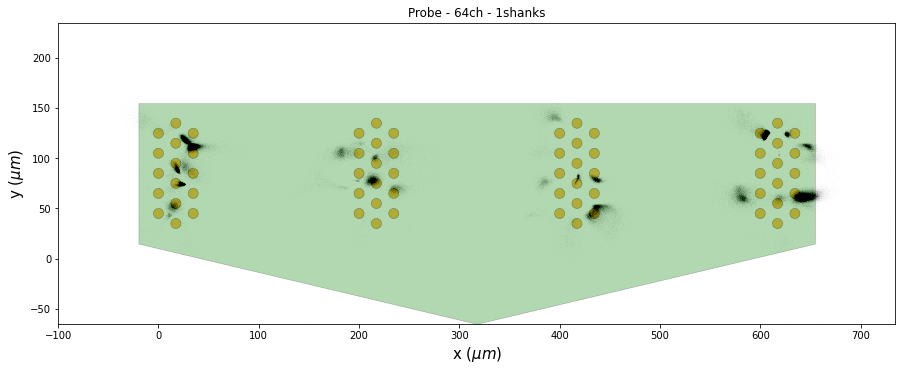

In [24]:
probe = rec_preprocessed.get_probe()
fig, ax = plt.subplots(figsize=(15, 10))
plot_probe(probe, ax=ax)
ax.scatter(peak_locations['x'], peak_locations['y'], color='k', s=1, alpha=0.002)
ax.set_xlim(probe_bounds_x)
ax.set_ylim(probe_bounds_y)

### Compute nearest neighbors between spikes over chunks of the recording
- sparse_euclidean computes the euclidean distance between the k closest channels to the spike's peak channel

In [25]:
import numba

In [26]:
@numba.jit(fastmath=True, cache=True)
def sparse_euclidean(x, y, n_samples, n_dense):
    """Euclidean distance metric over sparse vectors, where first n_dense
    elements are indices, and n_samples is the length of the second dimension
    """
    # break out sparse into columns and data
    x_best = x[:n_dense]  # dense indices
    x = x[n_dense:]
    y_best = y[:n_dense]
    y = y[n_dense:]
    result = 0.0

    xi = 0
    for xb in x_best:
        calc = False
        yi = 0
        for yb in y_best:
            if xb == yb:
                calc = True
                # calculate euclidean
                for i in range(n_samples):
                    result += (x[xi * n_samples + i] - y[yi * n_samples + i]) ** 2

            yi += 1
        if calc == False:
            # add x squared
            for i in range(n_samples):
                result += x[xi * n_samples + i] ** 2
        xi += 1
    yi = 0
    for yb in y_best:
        calc = False
        for xb in x_best:
            if xb == yb:
                calc = True
        if calc == False:
            # add y squared
            for i in range(n_samples):
                result += y[yi * n_samples + i] ** 2

        yi += 1
    return np.sqrt(result)

In [27]:
# HACK: this function only exists because I couldn't get the spikeinterface one to work...
def retrieve_padded_trace(
    recording, start_frame, end_frame, margin_frames, channel_ids=None
):
    """ 
    NOTE: I tried using the built in spikeinterface function for this but 
    recieved an error. 
    """
    # get the padding
    _pre = np.max([0, start_frame - margin_frames])
    _post = np.min([n_frames, end_frame + margin_frames])

    traces = recording.get_traces(
        start_frame=_pre, end_frame=_post, channel_ids=channel_ids
    )
    # append zeros if this chunk exists near the border
    if _pre < margin_frames:
        traces = np.vstack([np.zeros((margin_frames - _pre, traces.shape[1])), traces])
    if _post < margin_frames:
        traces = np.vstack([traces, np.zeros((margin_frames - _post, traces.shape[1]))])
    return traces

In [28]:
from sklearn.utils import check_random_state
from pynndescent import NNDescent
from spikeinterface.toolkit import get_channel_distances

In [29]:
### Parameters
refractory_period_ms = 1.0 # number of milliseconds surrounding spike to not allow neighborhood
time_window_s = 60*5 # window for sampling nearest neighbors
margin_ms = 100 # margin for chunking
spike_pre_ms = 1 # time prior to peak
spike_post_ms = 1 # time after peak
n_channel_neighbors = 8 # number of neighbors per channel 
n_neighbors = 5 # number of neighbors for graph construction
knn_verbose = True # whether to make knn computation verbose
low_memory = False # memory usage
n_jobs = -1 # number of jobs to perform computations over

In [30]:
# functions for nearest-neighbors search tree
def get_n_trees_iters(X):
    n_trees = min(64, 5 + int(round((X.shape[0]) ** 0.5 / 20.0)))
    n_iters = max(5, int(round(np.log2(X.shape[0]))))
    return n_trees, n_iters

def swap_elements(l, idx1, idx2):
    i1 = l[idx1]
    i2 = l[idx2]
    l[idx1] = i2
    l[idx2] = i1
    return l

In [31]:
recording = rec_preprocessed

In [32]:
# prepare neighborhood parameters
fs = recording.get_sampling_frequency()
n_frames = recording.get_num_frames()
duration = n_frames/fs
time_window_frames = fs * time_window_s
margin_frames = int(margin_ms/1000*fs)
spike_pre_frames = int(spike_pre_ms/1000*fs)
spike_post_frames = int(spike_post_ms/1000*fs)
n_channels = recording.get_num_channels()
n_samples = spike_pre_frames + spike_post_frames

In [33]:
margin_frames

3000

In [34]:
# get channel distances from one another
channel_distance = get_channel_distances(recording)

# get nearest neighbors of channels
channel_neighbors = np.argsort(channel_distance, axis=1)[:,:n_channel_neighbors]

In [35]:
# divide the recording into chunks of time_window_s seconds
n_chunks = int(np.ceil(n_frames / time_window_frames))

In [36]:
from tqdm.auto import tqdm

In [37]:
def get_chunk_spike_waveforms(
    recording,
    start_frame,
    end_frame,
    peaks,
    channel_neighbors,
    spike_pre_frames=30,
    spike_post_frames=30,
    n_channel_neighbors=5,
    margin_frames=3000,
):
    """ Grabs the spike waveforms for a chunk of a recording
    arguments: 
    
    returns:
        all_spikes: spike waveforms
        all_chan_idx: channel indices of nearest neighbors
        peaks_in_chunk_idx: index of spikes in this chunk
    """
    # grab the trace
    traces = retrieve_padded_trace(
        recording, start_frame, end_frame, margin_frames, channel_ids=None
    )

    # find the peaks that exist in this sample
    peaks_in_chunk_mask = (peaks["sample_ind"] >= start_frame) & (
        peaks["sample_ind"] <= end_frame
    )

    # get the peaks in this chunk
    peaks_chunk = peaks[peaks_in_chunk_mask]
    # get the index of which peaks are in this chunk
    peaks_in_chunk_idx = np.where(peaks_in_chunk_mask)[0]
    if len(peaks_in_chunk_idx) == 0:
        return None

    # add peaks indices to list
    

    # prepare an array of spikes to populate (n_spikes * channels * frames)
    all_spikes = np.zeros(
        (len(peaks_chunk), n_channel_neighbors, spike_pre_frames + spike_post_frames,)
    )
    # prepare an array of channels
    all_chan_idx = np.zeros((len(peaks_chunk), n_channel_neighbors))

    # for each spike in the sample, add it to the
    for spike_i, (sample_ind, channel_ind, amplitude, segment_ind) in enumerate(
        peaks_chunk
    ):
        spike_start = sample_ind + margin_frames - spike_pre_frames - start_frame
        spike_end = sample_ind + margin_frames + spike_post_frames - start_frame
        all_spikes[spike_i] = traces[
            spike_start:spike_end, channel_neighbors[channel_ind]
        ].T
        all_chan_idx[spike_i] = channel_neighbors[channel_ind]
        
        
    return all_spikes, all_chan_idx, peaks_in_chunk_idx

In [38]:
def get_spike_nearest_neighbors(
    all_spikes, n_neighbors, low_memory, knn_verbose, n_jobs, max_candidates=60
):
    # flatten spikes
    all_spikes_flat = np.reshape(
        all_spikes, (len(all_spikes), np.product(all_spikes.shape[1:]))
    )

    # add channel indices to channel values (for graph construction)
    all_spikes_flat = np.hstack([all_chan_idx, all_spikes_flat])

    # get parameters for NN search tree
    n_trees, n_iters = get_n_trees_iters(all_spikes_flat)

    # we are using the default nearest neighbors approach from UMAP
    #   with a sparse euclidean metric approach over channels 
    #   Q: is euclidean the right metric?
    knn_search_index = NNDescent(
        all_spikes_flat,
        metric=sparse_euclidean,
        metric_kwds={"n_samples": n_samples, "n_dense": n_channel_neighbors},
        n_neighbors=n_neighbors + 1,
        random_state=check_random_state(None),
        n_trees=n_trees,
        n_iters=n_iters,
        max_candidates=max_candidates,
        low_memory=low_memory,
        n_jobs=n_jobs,
        verbose=knn_verbose,
        compressed=False,
    )
    knn_indices, knn_distances = knn_search_index.neighbor_graph

    # BUG: nndescent finding some elements which are not closest to themselves.
    #   they are always second closest to themselves, and the distance is computed to be 0
    #   very small proportion of events
    # HACK: switch back errors
    # computed neighbors where an element is *not* closest to itself
    nn_errors = np.where(knn_indices[:, 0] != np.arange(len(knn_indices)))[0]
    # correct by swapping
    for nn_error in nn_errors:
        correct_match = np.where(knn_indices[nn_error] == nn_error)[0][0]
        knn_indices[nn_error] = swap_elements(knn_indices[nn_error], correct_match, 0)

    return knn_indices, knn_distances

In [39]:
peaks_in_chunk_idx_list = []
knn_indices_list = []
knn_distances_list = []

# for each chunk grab spike nearest neighbors
# TODO: this can be parallelized (although nearest neighbors is already 
#    parallelized, and bandwidth is limited for reading from raw data)
for chunk in tqdm(range(n_chunks-1)):
    # set the start and end frame to grab for this chunk
    start_frame = int(chunk * time_window_frames)
    end_frame = int((chunk + 2) * time_window_frames)
    if end_frame > n_frames:
        end_frame = n_frames
        
    # grab all spikes
    all_spikes, all_chan_idx, peaks_in_chunk_idx = get_chunk_spike_waveforms(
        recording,
        start_frame,
        end_frame,
        peaks,
        channel_neighbors,
        spike_pre_frames=spike_pre_frames,
        spike_post_frames=spike_post_frames,
        n_channel_neighbors=n_channel_neighbors,
        margin_frames=margin_frames,
    )
    
    # grab nearest neighbors
    knn_indices, knn_distances = get_spike_nearest_neighbors(
        all_spikes, 
        n_neighbors = n_neighbors, 
        low_memory = low_memory, 
        knn_verbose = knn_verbose, 
        n_jobs = n_jobs
    )
    
    # get value relative to absolute spike number in dataset
    knn_indices_abs = peaks_in_chunk_idx[knn_indices][:, 1:]
    #knn_indices += start_frame # offset 
    knn_indices_list.append(knn_indices_abs)
    knn_distances_list.append(knn_distances[:, 1:])
    
    # add peaks indices to list
    peaks_in_chunk_idx_list.append(peaks_in_chunk_idx)

  0%|          | 0/14 [00:00<?, ?it/s]

Mon Mar 14 11:57:46 2022 Building RP forest with 15 trees
Mon Mar 14 11:57:47 2022 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
	 6  /  15
	 7  /  15
	 8  /  15
	 9  /  15
	 10  /  15
	Stopping threshold met -- exiting after 10 iterations
Mon Mar 14 11:58:58 2022 Building RP forest with 15 trees
Mon Mar 14 11:58:58 2022 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
	 6  /  15
	 7  /  15
	 8  /  15
	 9  /  15
	Stopping threshold met -- exiting after 9 iterations
Mon Mar 14 12:00:17 2022 Building RP forest with 14 trees
Mon Mar 14 12:00:18 2022 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
	 6  /  15
	 7  /  15
	 8  /  15
	Stopping threshold met -- exiting after 8 iterations
Mon Mar 14 12:01:22 2022 Building RP forest with 14 trees
Mon Mar 14 12:01:22 2022 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
	 6  /  15
	 7  /  15
	 8  /  15
	St

In [40]:
peaks_in_chunk_idx

array([199244, 199245, 199246, ..., 221080, 221081, 221082])

### Merge nearest neighbors graphs over the full recording

In [157]:
def merge_nn_dicts(peaks, n_neighbors, peaks_in_chunk_idx_list, knn_indices_list, knn_distances_list):
    """merge together peaks_in_chunk_idx_list and knn_indices_list
    to build final graph
    """
    
    # ensure that n neighbors is an even number
    if n_neighbors %2 != 0:
        raise ValueError('n_neighbors ({}) must be an even number'.format(n_neighbors))
    
    nn_index_array = np.zeros((len(peaks), n_neighbors * 2), dtype=int) - 1
    nn_distance_array = np.zeros((len(peaks), n_neighbors * 2), dtype=float)
    end_last = -1
    # for each nn graph
    for idxi, (peaks_in_chunk_idx, knn_indices, knn_distances) in enumerate(
        zip(peaks_in_chunk_idx_list, knn_indices_list, knn_distances_list)
    ):
        # 
        nn_index_array[peaks_in_chunk_idx[peaks_in_chunk_idx > end_last], :5] = knn_indices[
            peaks_in_chunk_idx > end_last
        ]
        nn_index_array[peaks_in_chunk_idx[peaks_in_chunk_idx <= end_last], 5:] = knn_indices[
            peaks_in_chunk_idx <= end_last
        ]
        nn_distance_array[peaks_in_chunk_idx[peaks_in_chunk_idx > end_last], :5] = knn_distances[
            peaks_in_chunk_idx > end_last
        ]
        nn_distance_array[peaks_in_chunk_idx[peaks_in_chunk_idx <= end_last], 5:] = knn_distances[
            peaks_in_chunk_idx <= end_last
        ]
        # double up neighbors the beginning, since we only sample these once
        if idxi == 0:
            nn_index_array[peaks_in_chunk_idx, int(n_neighbors/2):] = knn_indices
            nn_distance_array[peaks_in_chunk_idx, 5:] = knn_distances
        # double up neighbors in the end, since we only sample these once
        if idxi == len(peaks_in_chunk_idx_list) - 1:
            nn_index_array[
                peaks_in_chunk_idx[peaks_in_chunk_idx > end_last], 5:
            ] = knn_indices[peaks_in_chunk_idx > end_last]
            nn_distance_array[
                peaks_in_chunk_idx[peaks_in_chunk_idx > end_last], 5:
            ] = knn_distances[peaks_in_chunk_idx > end_last]

        end_last = peaks_in_chunk_idx[-1]
    return nn_index_array, nn_distance_array

In [158]:
# merge together chunked nearest neighbors graphs
nn_idx, nn_dist = merge_nn_dicts(peaks, n_neighbors, peaks_in_chunk_idx_list, knn_indices_list, knn_distances_list)

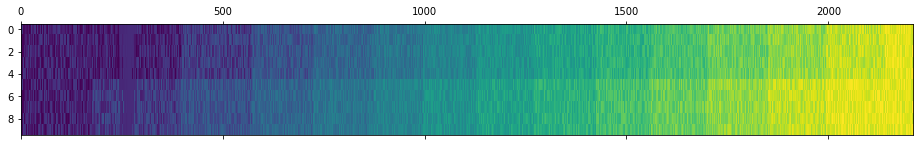

In [159]:
plt.matshow(nn_list[::100].T, aspect='auto')

In [166]:
nn_list.shape

(221083, 10)

In [160]:
np.save(peak_folder / 'nearest_neighbor_index.npy', nn_idx)
np.save(peak_folder / 'nearest_neighbor_distances.npy', nn_dist)